In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [24]:
pgroup='p20774'
runnumber = 380

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0380


'/sf/alvra/data/p20774/raw/run0380-RuRhTEA_RuL3_timescan_2840p3eV_002/meta/scan.json'

In [25]:
#fc = FileChooser('/sf/alvra/data/p20269/raw')
#fc.use_dir_icons = True
#display(fc)

In [26]:
#jsonfile = copy.copy(fc.selected)
#jsonfile

# Single scan, WITHOUT TT correction

In [27]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'

#######################################################################################################33
from sfdata import SFScanInfo
try:
    scan = SFScanInfo(jsonfile)

    scan = remove_JF_from_scan(scan)

    flag = False

    Timezero_mm = 147.4889

    try:
        flag = True
        Timezero_mm = get_timezero_NBS(jsonfile)
    except:
        Timezero_mm = Timezero_mm

    (DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
     DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, 
     Izero_pump, Izero_unpump, correlation1, correlation2, Delay_mm, Delay_fs, goodshots1, goodshots2) = \
    XAS_delayscan_noTT_2diodes(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

    if scan.parameters['units'] == ['nS']:
        Delay_fs = scan.values[:len(Delay_fs)]
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values[:len(Delay_fs)]
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

    run_name = jsonfile.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)

    save_data_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs,
                                DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1,
                                DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, goodshots2)
except:
    print ('json file not ready yet!!')

Processing: run0380-RuRhTEA_RuL3_timescan_2840p3eV_002
Step 42 of 44: Processing acq0042

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 494 pump and 494 unpump shots
(118,) shots out of (494,) survived
(116,) shots out of (494,) survived
Step 42 of 44: Processed acq0042
correlation Diode1 (all shots) = 0.984748690356935
correlation Diode2 (all shots) = 0.9811745628197782
------------------------------
Processed 42 out of 44 files
--------------------

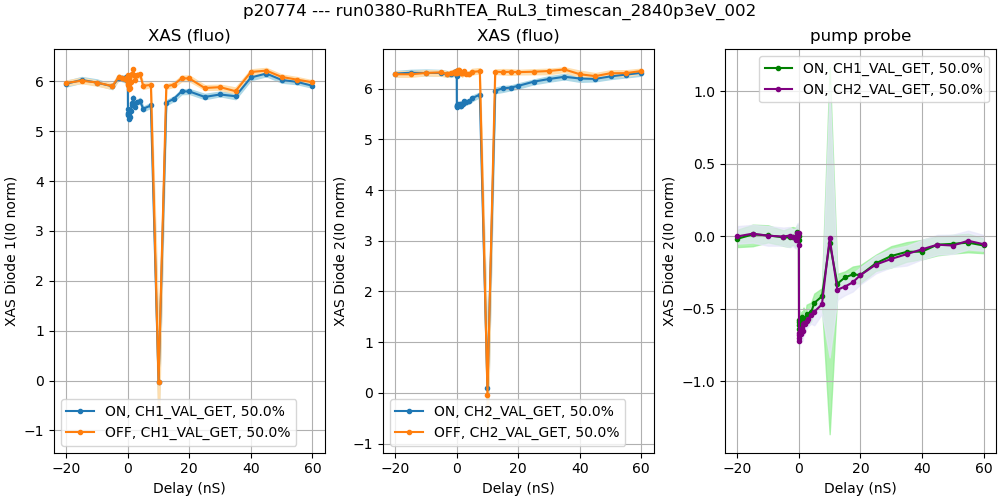

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS1_pump = DataDiode1_pump[:,0]
err1_low_pump = DataDiode1_pump[:,1]
err1_high_pump = DataDiode1_pump[:,2]
XAS1_unpump = DataDiode1_unpump[:,0]
err1_low_unpump = DataDiode1_unpump[:,1]
err1_high_unpump = DataDiode1_unpump[:,2]
XAS1_pump_probe = Pump_probe_Diode1[:,0]
err1_low_pump_probe = Pump_probe_Diode1[:,1]
err1_high_pump_probe = Pump_probe_Diode1[:,2]

XAS2_pump = DataDiode2_pump[:,0]
err2_low_pump = DataDiode2_pump[:,1]
err2_high_pump = DataDiode2_pump[:,2]
XAS2_unpump = DataDiode2_unpump[:,0]
err2_low_unpump = DataDiode2_unpump[:,1]
err2_high_unpump = DataDiode2_unpump[:,2]
XAS2_pump_probe = Pump_probe_Diode2[:,0]
err2_low_pump_probe = Pump_probe_Diode2[:,1]
err2_high_pump_probe = Pump_probe_Diode2[:,2]

units = scan.parameters['units'][0]
ax1.plot(Delay_fs, XAS1_pump, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS1_unpump, label='OFF, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay ({})".format(units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS2_pump, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Delay_fs, XAS2_unpump, label='OFF, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax2.set_xlabel("Delay ({})".format(units))
ax2.set_ylabel ("XAS Diode 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax3.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
ax3.fill_between(Delay_fs, err1_low_pump_probe, err1_high_pump_probe, alpha = 0.7, color='lightgreen')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))

ax3.plot(Delay_fs, XAS2_pump_probe, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),color='purple',marker='.')
ax3.fill_between(Delay_fs, err2_low_pump_probe, err2_high_pump_probe, alpha = 0.7, color='lavender')

ax3.set_xlabel("Delay ({})".format(units))
ax3.set_ylabel ("XAS Diode 2(I0 norm)")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

# ax1.set_ylim(1.068, 1.10)
# ax2.set_ylim(0.985, 1.015)eV
# ax3.set_ylim(-0.005, 0.02)
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(-3000, 10000)

plt.show()

#print(Delay_fs[0],Delay_fs[-1])

In [14]:
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS1_pump_probe)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,XAS1_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,3)),"fs")
#print("Position t0 =",np.round(t0_fs,5),"fs")
#print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 24.08456 fs
Width = 17.792 fs


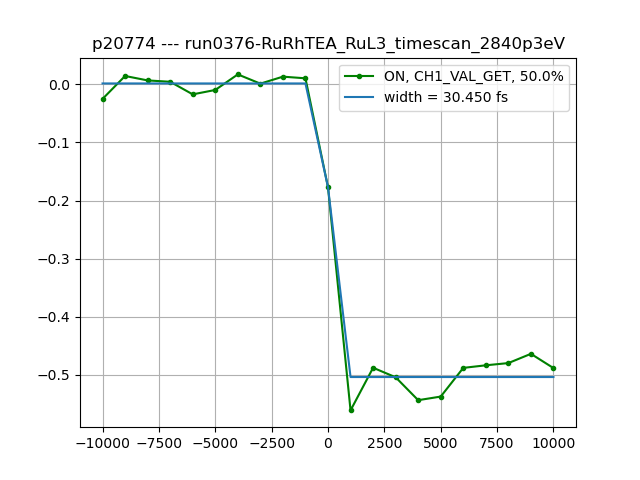

In [542]:
plt.figure()
plt.title(titlestring)
plt.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
plt.plot(Delay_fs, pp_fit, label = 'width = {:.3f} fs'.format(width_fs))
plt.legend(loc='best')
plt.grid()
plt.show()

## Error Bars

In [490]:
#### CH1 ####
XAS1_pump      = DataDiode1_pump[:,0]
err1_low_pump  = (DataDiode1_pump[:,1]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)
err1_high_pump = (DataDiode1_pump[:,2]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)

XAS1_unpump      = DataDiode1_unpump[:,0]
err1_low_unpump  = (DataDiode1_unpump[:,1]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)
err1_high_unpump = (DataDiode1_unpump[:,2]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)

XAS1_pump_probe       = Pump_probe_Diode1[:,0]
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = DataDiode2_pump[:,0]
err2_low_pump    = (DataDiode2_pump[:,1]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)
err2_high_pump   = (DataDiode2_pump[:,2]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)

XAS2_unpump      = DataDiode2_unpump[:,0]
err2_low_unpump  = (DataDiode2_unpump[:,1]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)
err2_high_unpump = (DataDiode2_unpump[:,2]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)

XAS2_pump_probe       = Pump_probe_Diode2[:,0]
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

# Averaging 2 diodes

In [491]:
XAS_mean_pump = (XAS1_pump+XAS2_pump)/2
XAS_mean_unpump = (XAS1_unpump+XAS2_unpump)/2

offset1 = np.average(XAS1_unpump[0:5])
offset2 = np.average(XAS2_unpump[0:5])

ave_unpump = (XAS1_unpump-offset1 + XAS2_unpump-offset2)/2
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-offset1 + XAS2_pump-offset2)/2
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

##Average first, subtract later
ave_pp1 = ave_pump - ave_unpump
#ave_pp_err1 = np.sqrt((ave_unpump_err_h-ave_unpump_err_l)**2+np.square(ave_pump_err_h-ave_pump_err_l)**2)
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

##Average of the difference signals
factor = 1
ave_pp2 = (XAS1_pump_probe*factor + XAS2_pump_probe*factor)/2
ave_pp_err_l2 = ((err1_low_pump_probe + err2_low_pump_probe)/2)*factor
ave_pp_err_h2 = ((err1_high_pump_probe + err2_high_pump_probe)/2)*factor

# Plotting Averged Diodes with error bars

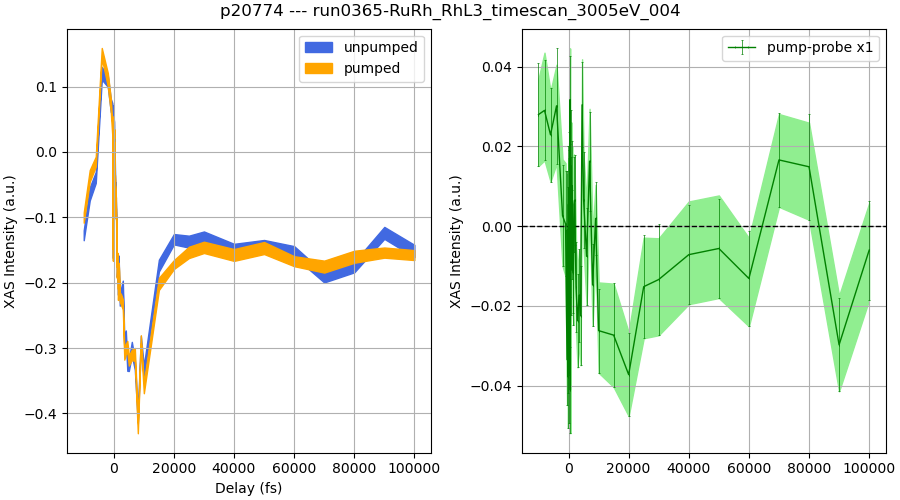

In [492]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

# ax1.axes.errorbar(Delay_fs,ave_unpump, ave_unpump_err_l ,ave_unpump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='unpumped')
# ax1.axes.errorbar(Delay_fs, ave_pump,  ave_pump_err_l,  ave_pump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='pumped')

#ax1.plot(Delay_fs,ave_unpump,lw=1,marker='o',markersize=3,label='unpumped')
units = scan.parameters['units'][0]
ax1.fill_between(Delay_fs,ave_unpump-ave_unpump_err_l, ave_unpump+ave_unpump_err_h,color='royalblue',label='unpumped')
ax1.fill_between(Delay_fs,ave_pump-ave_pump_err_l, ave_pump+ave_pump_err_h,color='orange',label='pumped')

ax1.set_xlabel('Delay ({})'.format(units))
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.legend(loc='best')
#ax1.set_xlim(-400,900)

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Delay_fs, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))
#ax2.plot(Delay_fs,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
ax2.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.axhline(0,ls='--',c='k',lw=1)
ax1.set_xlabel('Delay ({})'.format(units))
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.grid()
ax2.legend(loc='best')
#ax2.set_xlim(-400,400)



## Check correlation for a certain delay point

In [480]:
chosen_delay_fs = 500

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(182,) shots out of (492,) survived
Correlation (all shots)      = 0.9912328412296281
Correlation (filtered shots) = 0.9993283092312074
Delay = 507.34 fs


In [481]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 7.48559084397332, Median (filtered) = 7.481015834171495
MAD (all) = 0.21141559303507726, MAD(filtered) = 0.12902289934546876
MAD/median (all) = 2.8243006790210665%, MAD/median (filtered) = 1.7246708495940213%


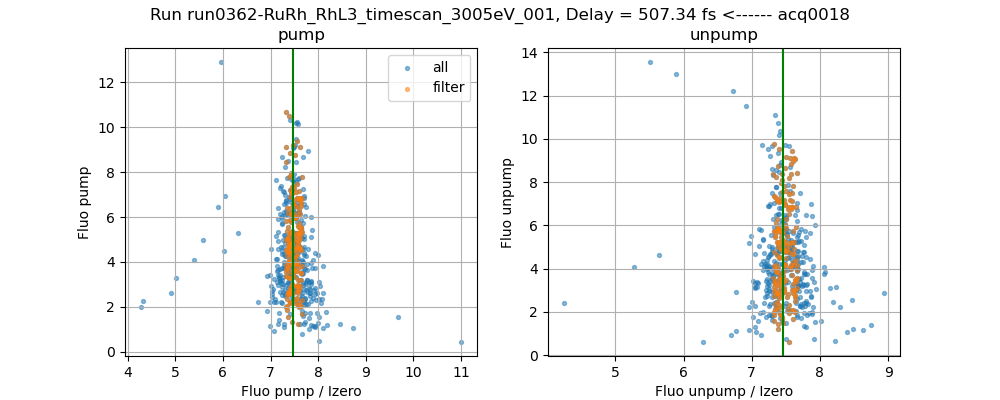

In [482]:
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.legend(loc='best')
plt.xlabel('Fluo pump / Izero')
plt.ylabel('Fluo pump')
plt.grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

plt.subplot(122)
plt.title('unpump')
plt.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.xlabel('Fluo unpump / Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

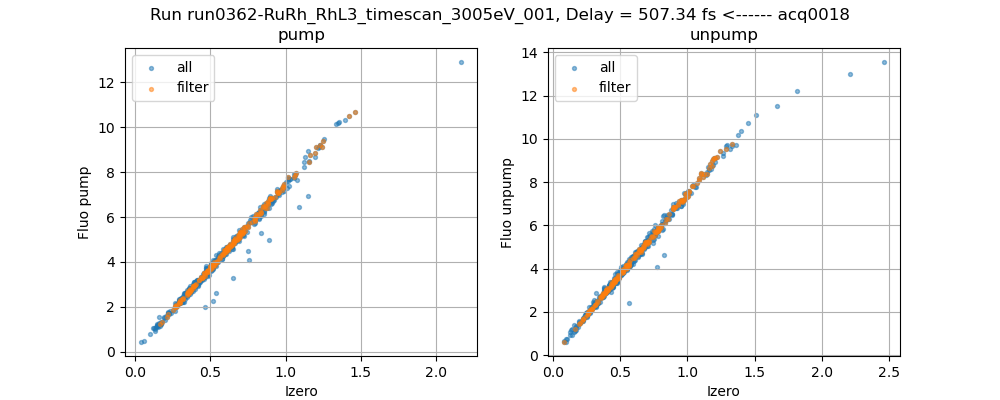

In [483]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump, Fluo_pump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump, Fluo_unpump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

## Process files in a loop

In [328]:
pgroup='p20774'
#runlist = [790]
runlist = np.arange(339, 340)
#runlist = [179]
print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

1 runs: [339]


['/sf/alvra/data/p20774/raw/run0339-RuRh_ClK_timescan_2819p7eV_001/meta/scan.json']

In [293]:
quantile_corr = 0.6
Timezero_mm = 147.48892    ## this in mm from the YAG scans

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode1_pump_all = []
DataDiode1_unpump_all = []
Pump_probe1_all = []
goodshots1_all = []

DataDiode2_pump_all = []
DataDiode2_unpump_all = []
Pump_probe2_all = []
goodshots2_all = []

Delay_fs_all = []

for json_file in jsonlist:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    flag = False
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    DataDiode1_pump = []
    DataDiode1_unpump = []
    Pump_probe_Diode1 = []
    
    DataDiode2_pump = []
    DataDiode2_unpump = []
    Pump_probe_Diode2 = []
    
    (DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
     DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, _, _, _, _, 
     Delay_mm, Delay_fs, goodshots1, goodshots2) = XAS_delayscan_noTT_2diodes(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
    
    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
    DataDiode1_pump_all.append(DataDiode1_pump)
    DataDiode1_unpump_all.append(DataDiode1_unpump)
    Pump_probe1_all.append(Pump_probe_Diode1)    
    goodshots1_all.append(goodshots1)
    
    DataDiode2_pump_all.append(DataDiode2_pump)
    DataDiode2_unpump_all.append(DataDiode2_unpump)
    Pump_probe2_all.append(Pump_probe_Diode2) 
    goodshots2_all.append(goodshots2)
    
    Delay_fs_all.append(Delay_fs)
    
    run_name = json_file.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    
#    save_data_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs,
#                                DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1,
#                                DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, goodshots2)
    
    print ('Processed run {}'.format(json_file.split('/')[-3]))

DataDiode1_pump_all = np.array(DataDiode1_pump_all)
DataDiode1_unpump_all = np.array(DataDiode1_unpump_all)
Pump_probe1_all = np.array(Pump_probe1_all)
goodshots1_all = np.array(goodshots1_all)
DataDiode2_pump_all = np.array(DataDiode2_pump_all)
DataDiode2_unpump_all = np.array(DataDiode2_unpump_all)
Pump_probe2_all = np.array(Pump_probe2_all)
goodshots2_all = np.array(goodshots2_all)
Delay_fs_all = np.array(Delay_fs_all)


Processing: run0294-MB_EtOH_10mM_timescan_2474.75eV_short_002
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY  988 / 1001 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 988 / 1001 -> 1% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 486 pump and 486 unpump shots
(178,) shots out of (486,) survived
(181,) shots out of (486,) survived
Step 56 of 56: Processed acq0056
correlation Diode1 (all shots) = 0.9777633550921997
correlation Diode2 (all shots) = -0.04905529029458594
------------------------------
Processed 56 out of 56 files
------------

In [294]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

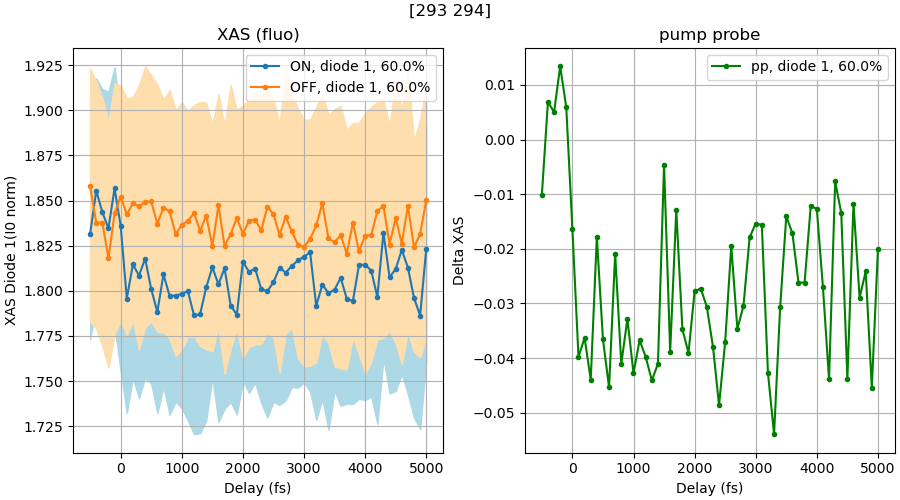

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(runlist, fontsize = 12)

XAS1_pump = np.mean(DataDiode1_pump_all, axis=0)[:,0]
err1_low_pump = (XAS1_pump - np.mean(DataDiode1_pump_all, axis=0)[:,1])/np.sqrt(len(runlist))
err1_high_pump = (np.mean(DataDiode1_pump_all, axis=0)[:,2]-XAS1_pump)/np.sqrt(len(runlist))
XAS1_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,0]
err1_low_unpump = (XAS1_unpump - np.mean(DataDiode1_unpump_all, axis=0)[:,1])/np.sqrt(len(runlist))
err1_high_unpump = (np.mean(DataDiode1_unpump_all, axis =0)[:,2]-XAS1_unpump)/np.sqrt(len(runlist))
XAS1_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,0]
err1_low_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,1]#/np.sqrt(len(patch))
err1_high_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS1_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS1_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS1_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

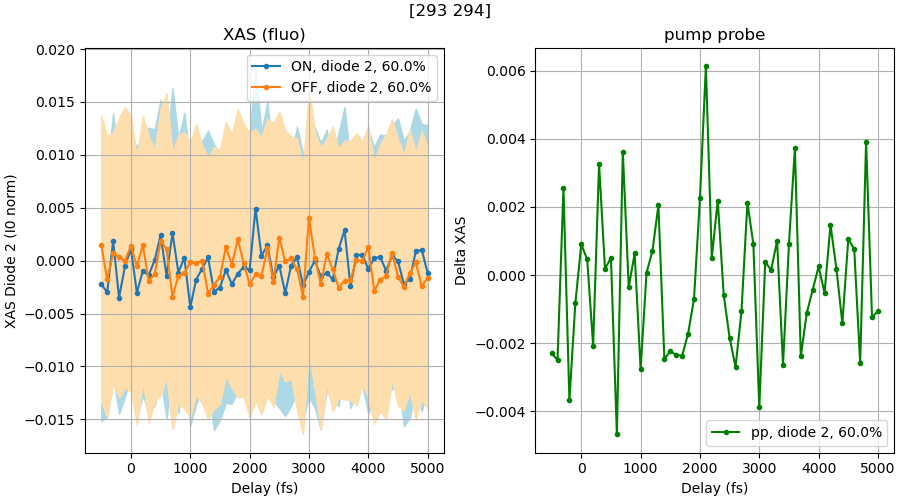

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(runlist, fontsize = 12)

XAS2_pump = np.mean(DataDiode2_pump_all, axis=0)[:,0]
err2_low_pump = (XAS2_pump - np.mean(DataDiode2_pump_all, axis=0)[:,1])/np.sqrt(len(runlist))
err2_high_pump = (np.mean(DataDiode2_pump_all, axis=0)[:,2]-XAS2_pump)/np.sqrt(len(runlist))
XAS2_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,0]
err2_low_unpump = (XAS2_unpump - np.mean(DataDiode2_unpump_all, axis=0)[:,1])/np.sqrt(len(runlist))
err2_high_unpump = (np.mean(DataDiode2_unpump_all, axis =0)[:,2]-XAS2_unpump)/np.sqrt(len(runlist))
XAS2_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,0]
err2_low_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,1]#/np.sqrt(len(patch))
err2_high_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS2_pump, label='ON, diode 2, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS2_unpump, label='OFF, diode 2, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 2 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS2_pump_probe, label='pp, diode 2, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()